# Checking implementation of integral using Cauchy's Theorem

We have ways of integrating along compelex contours, let's check how well we're doing using Cauchy's theorem.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact, plotlogf, plot_complex, plot_complex_surface
from scipy.optimize import newton
from scipy.integrate import quad
plt.style.use('dark_background')
%matplotlib widget

In [78]:
long_wl = 1.5e-4

A = SlabExact(scale=1e-5, Ts=[15, 1, 8, 1, 15],
              ns=np.array([1, 1.44, 1, 1.44, 1]), xrefs=[100, 40, 300, 40, 100],
              symmetric=True, wl=long_wl)

In [79]:
b = 1.25
def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - (x/b)**2, 0]
    return np.piecewise(x, conds, funcs)

f0 = quadratic_piecewise

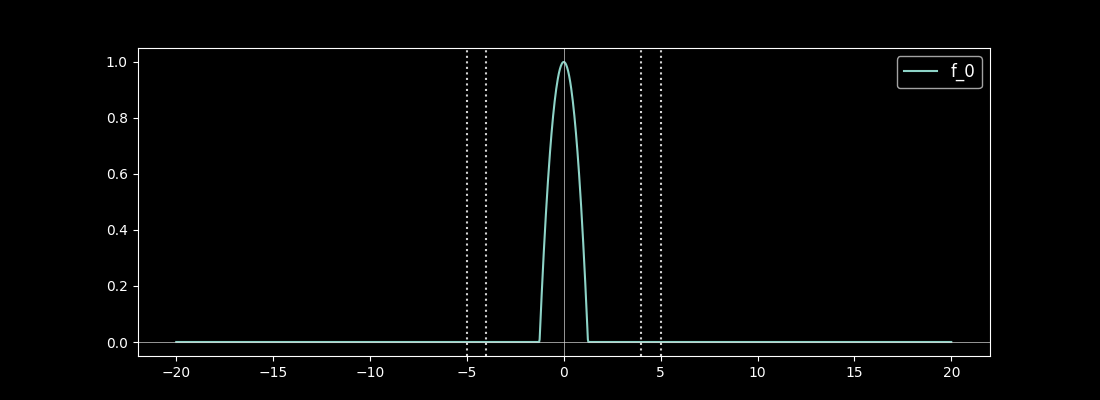

In [80]:
A.plot_field_1d(f0, figsize=(11,4), label='f_0');

## Determining integration path

First we do a path containing no poles

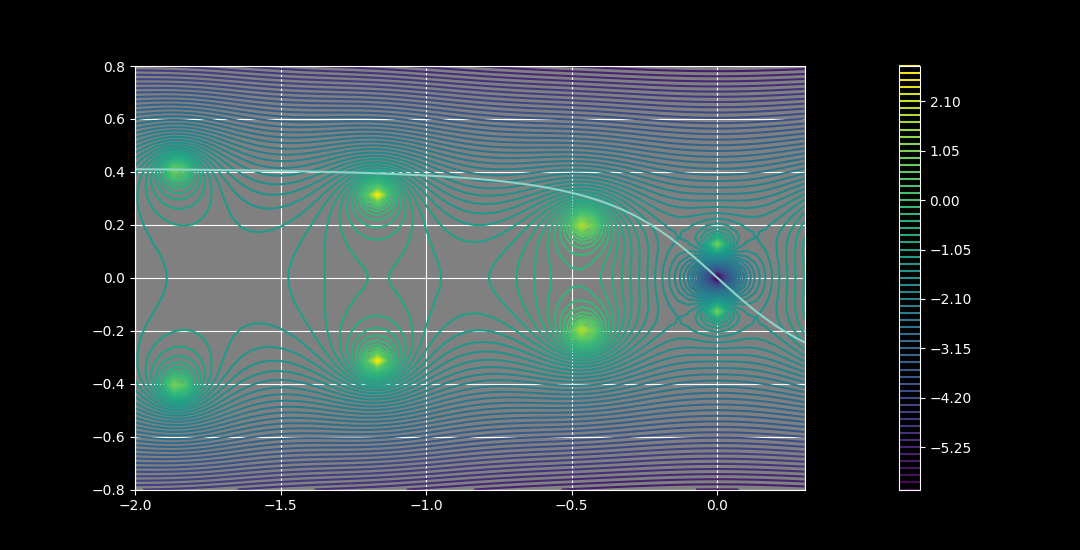

In [81]:
paper_method = False
rmin, rmax, rref = -2, .3, 70
imin, imax, iref = -.8, .8, 70
levels = 70

sdp_xs = np.linspace(rmin, rmax, rref)
sdp_ys = A.sdp_Z(sdp_xs)

x, z = 0, 0

plot_complex(A.spectral_integrand, rmin, rmax, imin, imax, fargs=(f0, x, z, -b, b, True, False, 'TE', paper_method),
                      iref=iref, rref=rref, levels=levels, figsize=(10.8,5.5), log_abs=True)

plt.plot(sdp_xs, sdp_ys, linewidth=1.5);


In [83]:
Z_leaky = newton(A.determinant_Z, np.array([-.5+.2j]), args=('TE', 'leaky'))
plt.plot(Z_leaky.real, Z_leaky.imag, marker='o', markersize=4, color='r');
Z_leaky

array([-0.45681753+0.20101986j])

In [84]:
# rmin, rmax, rref = -.6, -.4, 120
# imin, imax, iref = .1, .4, 120

# plot_complex_surface(A.spectral_integrand, rmin, rmax, imin, imax, fargs=(f0, x, z, -b, b, True, False, 'TE', paper_method),
#                      part='real', iref=iref, rref=rref, z_lims=[-1,1])

## Path:

Along real axis from $x=0$ to $x = -.25$, up to SDP and back.  This should integrate to zero (function).  Alternately, we do $x = 0$ to $x=-.5$ and include the leaky mode.

In [88]:
re_Z_lim = -.5

In [89]:
Propagator_Class = A.propagator()
paper_method = False


### Real part

In [130]:
P_real = Propagator_Class(A.real_contour(-.00001, re_Z_lim, 100), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

### Vertical part

In [131]:
P_vert = Propagator_Class(A.vertical_contour_sdp(re_Z_lim, 100), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

### SDP portion

In [132]:
P_sdp = Propagator_Class(A.sdp_contour(re_Z_lim, -.000001, 180), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

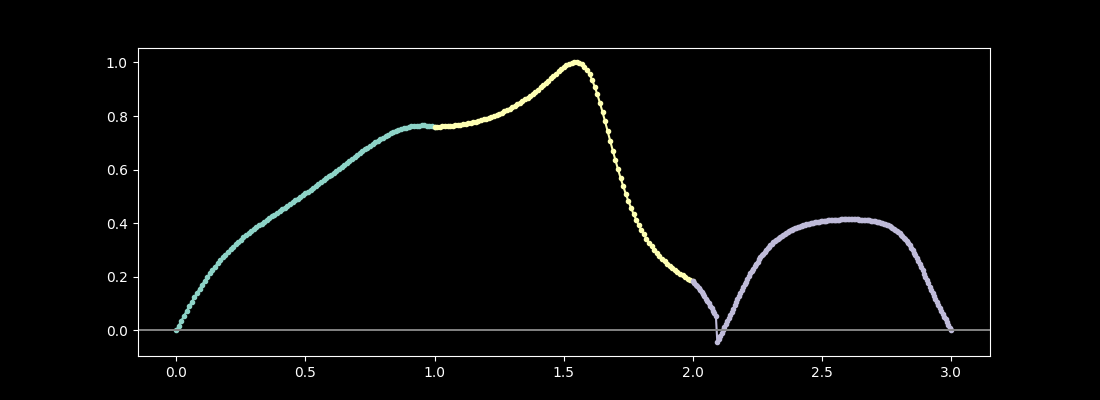

In [133]:
plt.close('all')
part='real'
fig, ax = P_real.plot_transform(part=part, xs=P_real.Ss);
P_vert.plot_transform(ax=ax, xs=P_vert.Ss+1, part=part);
P_sdp.plot_transform(ax=ax, xs=P_sdp.Ss+2);

### Leaky Mode portion

In [150]:
P_leaky = Propagator_Class(A.circular_contour(Z_leaky, 1e-6, 20, 'cw'), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

## Plot Integration Contour over Integrand and SDP

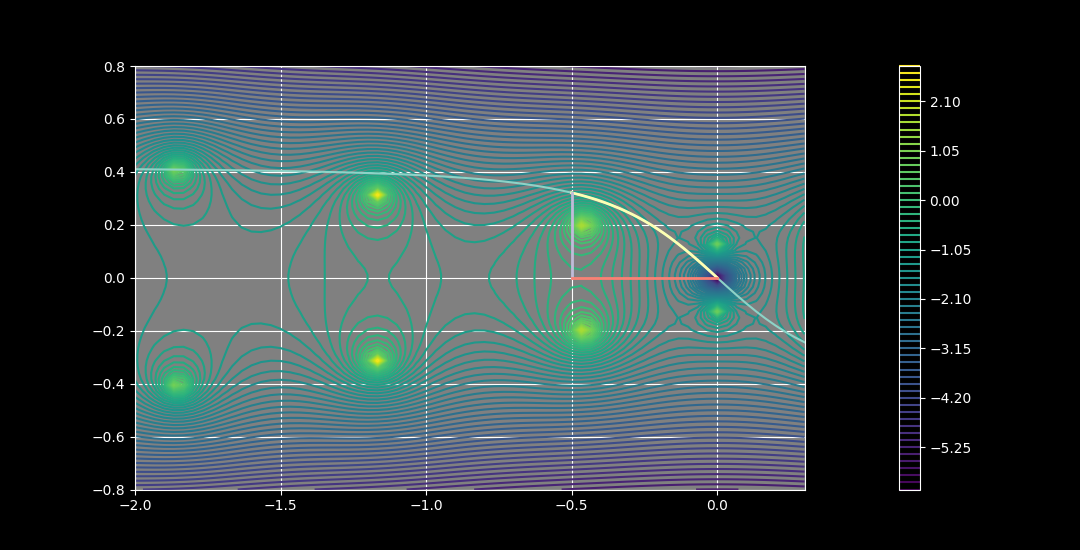

In [151]:
rmin, rmax, rref = -2, .3, 70
imin, imax, iref = -.8, .8, 70
levels = 70

sdp_xs = np.linspace(rmin, rmax, rref)
sdp_ys = A.sdp_Z(sdp_xs)

x, z = 0, 0

plot_complex(A.spectral_integrand, rmin, rmax, imin, imax, fargs=(f0, x, z, -b, b, True, False, 'TE', paper_method),
                      iref=iref, rref=rref, levels=levels, figsize=(10.8,5.5), log_abs=True)

plt.plot(sdp_xs, sdp_ys, linewidth=1.5);

plt.plot(P_sdp.Zs.real, P_sdp.Zs.imag, linewidth=2)
plt.plot(P_vert.Zs.real, P_vert.Zs.imag, linewidth=2)
plt.plot(P_real.Zs.real, P_real.Zs.imag, linewidth=2);


## Plots of Functions associated with each part of contour

In [154]:
full_path = lambda x: P_real.slice_propagate(x) + P_vert.slice_propagate(x,) + P_sdp.slice_propagate(x) - P_leaky.slice_propagate(x)
Full_path = lambda x,z: P_real.propagate(x,z) + P_vert.propagate(x,z) + P_sdp.propagate(x,z) - P_leaky.propagate(x,z)

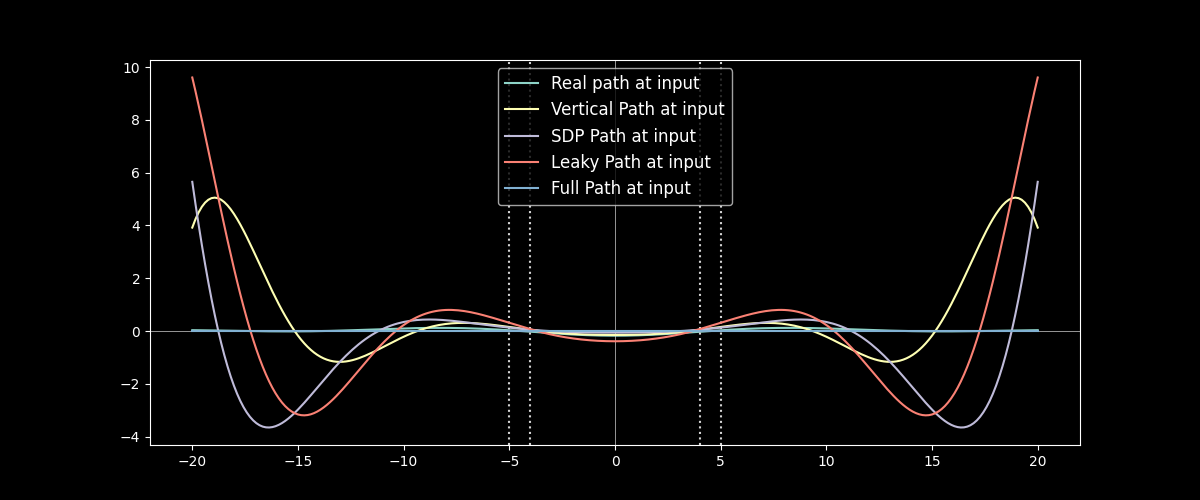

In [155]:
fig, ax = A.plot_field_1d(P_real.slice_propagate, label='Real path at input');
A.add_1d_plot(P_vert.slice_propagate, ax=ax, label='Vertical Path at input')
A.add_1d_plot(P_sdp.slice_propagate, ax=ax, label='SDP Path at input');
A.add_1d_plot(P_leaky.slice_propagate, ax=ax, label='Leaky Path at input')

A.add_1d_plot(full_path, label='Full Path at input', ax=ax);

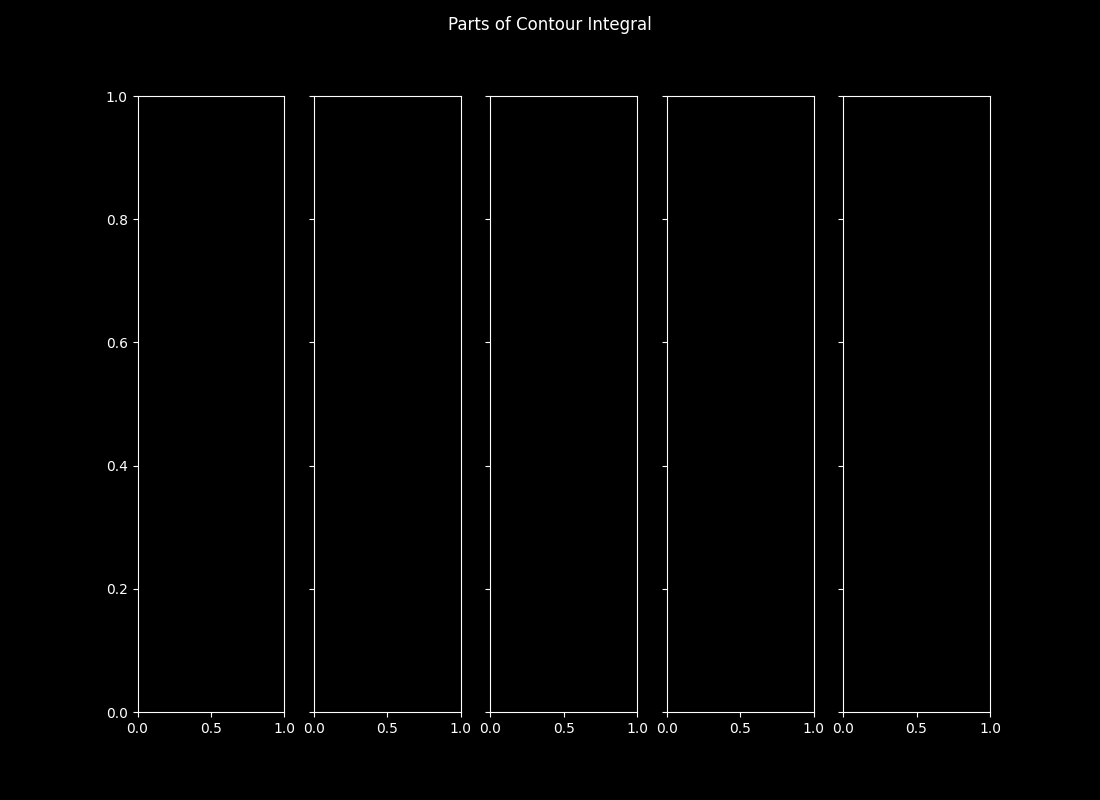

In [162]:
plt.close('all')
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(11,8))

zmin = 0
zmax = 100
zref = int((zmax-zmin)*40/2)
zs = np.linspace(zmin, zmax, zref)
fig.suptitle('Parts of Contour Integral');

In [163]:
A.add_2d_plot(P_real.propagate, zs=zs, ax=ax1, colorbar=True, colorbar_format='%0.1f', shrink=.9);
ax1.set_title('Real axis to x = %.1f' %re_Z_lim)

Text(0.5, 1.0, 'Real axis to x = -0.5')

In [164]:
A.add_2d_plot(P_vert.propagate, zs=zs, ax=ax2, colorbar=True, colorbar_format='%0.1f', shrink=.8);
ax2.set_title('Vertical path to SDP')

Text(0.5, 1.0, 'Vertical path to SDP')

In [165]:
A.add_2d_plot(P_sdp.propagate, zs=zs, ax=ax3, colorbar=True, colorbar_format='%0.1f', shrink=.8);
ax3.set_title('SDP portion')

Text(0.5, 1.0, 'SDP portion')

In [166]:
A.add_2d_plot(P_leaky.propagate, zs=zs, ax=ax4, colorbar=True, colorbar_format='%0.1f', shrink=.8);
ax4.set_title('Leaky portion')

Text(0.5, 1.0, 'Leaky portion')

In [167]:
A.add_2d_plot(Full_path, zs=zs, ax=ax5, colorbar=True, colorbar_format='%0.1e', part='norm', colorbar_nticks=3, shrink=.8);
ax5.set_title('Total Path Integral')

Text(0.5, 1.0, 'Total Path Integral')

## Surface Plots

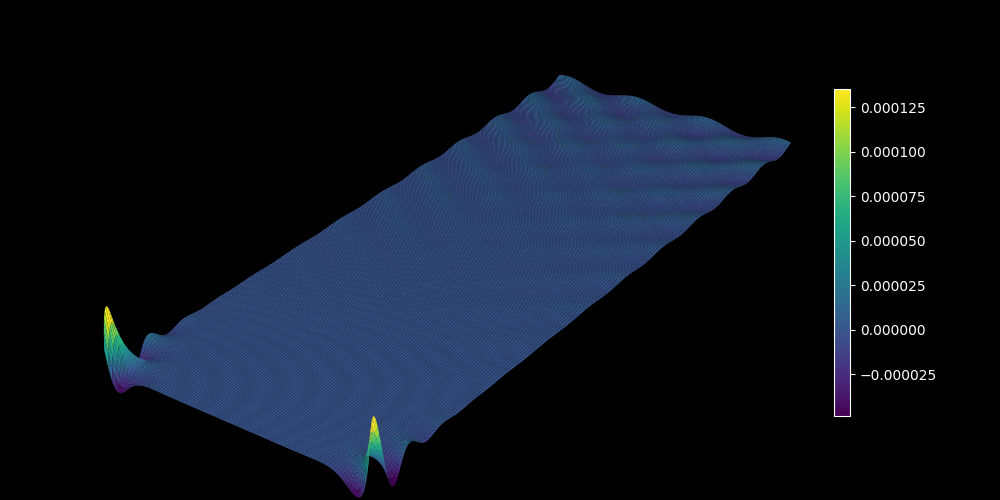

In [24]:
zmin = 0
zmax = 200
zref = int((zmax-zmin)*2)
zs = np.linspace(zmin, zmax, zref)
xs = np.linspace(-40,40, 100)
A.plot_field_2d_surface(Full_path, xs=xs, zs=zs, elev=30, azim=-55, zoom=2.5, rstride=1, cstride=1, 
                        colorbar=True, part='real');

In [67]:
# A.plot_field_2d_surface(P_vert.propagate, xs=xs, zs=zs, elev=30, azim=-55, zoom=2.5, rstride=1, cstride=1);

In [68]:
# A.plot_field_2d_surface(P_sdp.propagate, xs=xs, zs=zs, elev=30, azim=-55, zoom=2.5, rstride=1, cstride=1);

In [69]:
# A.plot_field_2d_surface(Full_path, xs=xs, zs=zs, elev=30, azim=-55, zoom=2.5, rstride=1, cstride=1);

## Examine integrand for particular x and z

In [74]:
x, z = 0,0

paper_method = True

Integrand_Real = (A.spectral_integrand(P_real.Zs, f0, x=x, z=z, Lx=-b, Rx=b, 
                                       class_A_only=True, paper_method=paper_method) * P_real.dZdS)[:-1] * P_real.dS

Integrand_Vertical = (A.spectral_integrand(P_vert.Zs, f0, x=x, z=z, Lx=-b, Rx=b,
                                           class_A_only=True, paper_method=paper_method) * P_vert.dZdS)[:-1] * P_vert.dS

Integrand_SDP = (A.spectral_integrand(P_sdp.Zs, f0, x=x, z=z, Lx=-b, Rx=b,
                                      class_A_only=True, paper_method=paper_method) * P_sdp.dZdS)[:-1] * P_sdp.dS

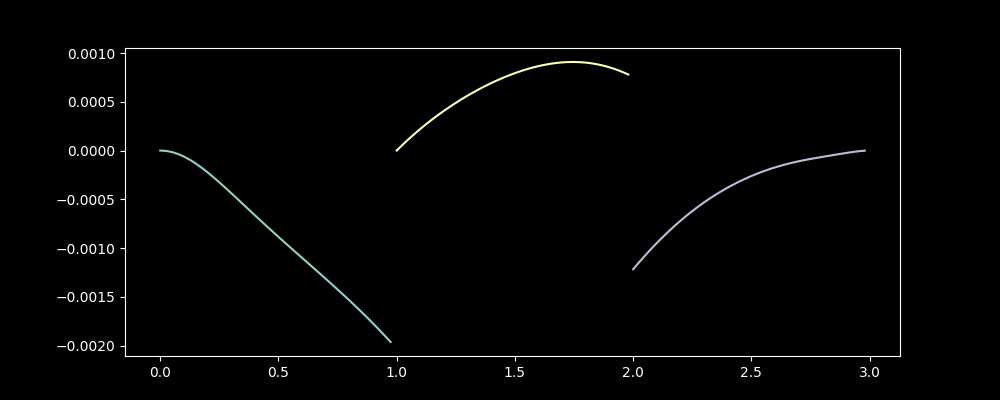

In [78]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10,4))
ax.plot(P_real.Ss[:-1], Integrand_Real.real);
ax.plot(P_vert.Ss[:-1]+1, Integrand_Vertical.real);
ax.plot(P_sdp.Ss[:-1]+2, Integrand_SDP.real);

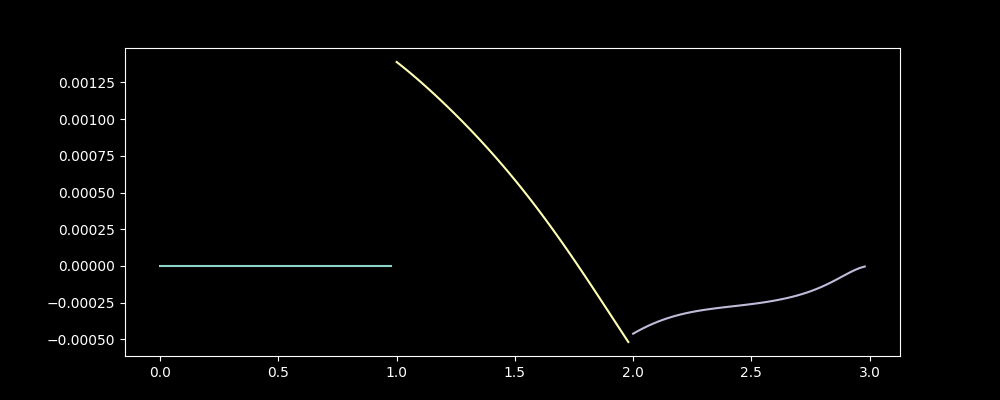

In [79]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10,4))
ax.plot(P_real.Ss[:-1], Integrand_Real.imag);
ax.plot(P_vert.Ss[:-1]+1, Integrand_Vertical.imag);
ax.plot(P_sdp.Ss[:-1]+2, Integrand_SDP.imag);

In [80]:
np.sum(Integrand_Real) + np.sum(Integrand_Vertical) + np.sum(Integrand_SDP)

(-0.02127725443870795+0.014606318348145606j)

## Circular Integration around non-singularity

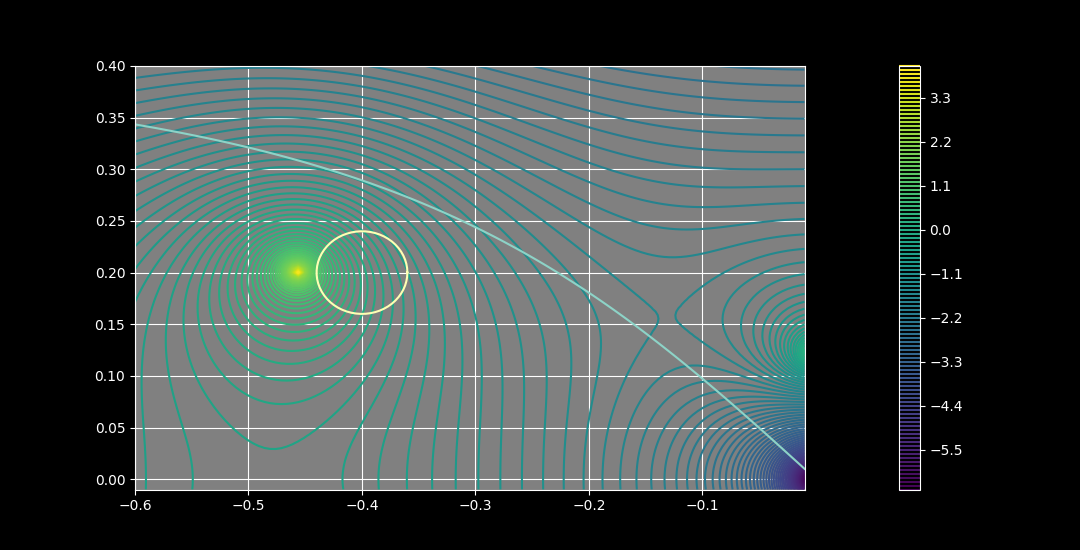

In [315]:
rmin, rmax, rref = -.6, -.01, 120
imin, imax, iref = -.01, .4, 120
levels = 120

sdp_xs = np.linspace(rmin, rmax, rref)
sdp_ys = A.sdp_Z(sdp_xs)

x, z = 0, 0

plot_complex(A.spectral_integrand, rmin, rmax, imin, imax, fargs=(f0, x, z, -b, b, True, False, 'TE', paper_method),
                      iref=iref, rref=rref, levels=levels, figsize=(10.8,5.5), log=True)

plt.plot(sdp_xs, sdp_ys, linewidth=1.5);
circ_contour = A.circular_contour(-.4 + .2j, 4e-2, 60)
plt.plot(circ_contour['Zs'].real, circ_contour['Zs'].imag);

In [327]:
circ_contour = A.circular_contour(-.4 + .2j, 4e-2, 100)

In [328]:
P_circ = Propagator_Class(circ_contour, f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

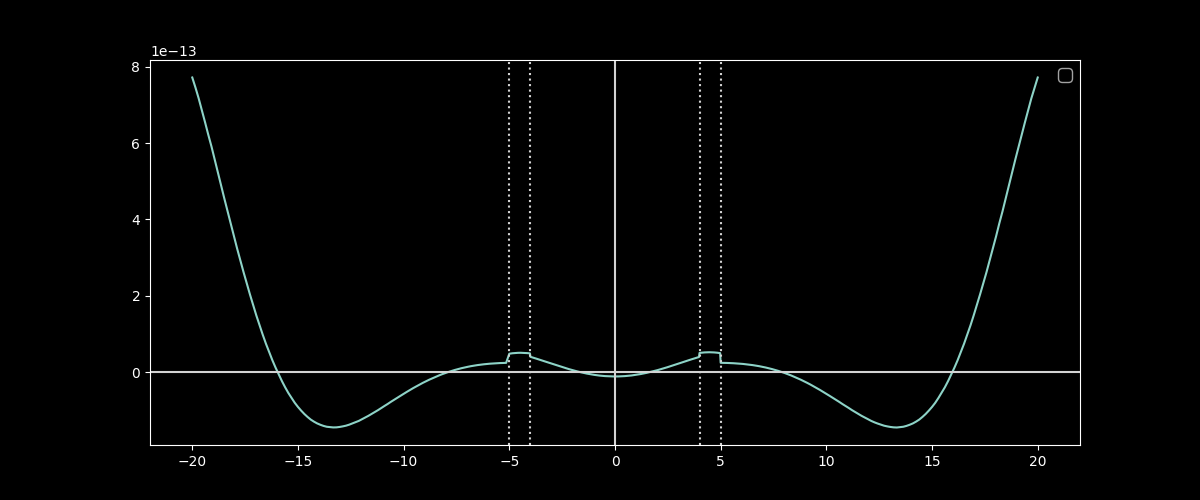

In [321]:
A.plot_field_1d(P_circ.slice_propagate)

In [335]:
# A.spectral_integrand(P_circ.Zs, f0, Lx=-b, Rx=b, paper_method=True)